# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arrow’ was built under R version 4.0.3”

Attaching package: ‘arrow’


The following object is masked from ‘p

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label="22_medical_records"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [3]:
data_outcomes = arrow::read_feather(glue("{output_path}/baseline_outcomes_220223.feather"))

In [4]:
model = "Identity(Records)+MLP"

In [5]:
predictions_wide = arrow::read_feather("/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data/predictions_220302/predictions_wide.feather") %>% mutate(eid = as.integer(as.character(eid))) %>% filter(model==!!model)

Warning message:
“Coercing dictionary values to R character factor levels”
Warning message:
“Coercing dictionary values to R character factor levels”


In [6]:
unique(arrow::read_feather("/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data/predictions_220302/predictions_wide.feather")$model)

Warning message:
“Coercing dictionary values to R character factor levels”
Warning message:
“Coercing dictionary values to R character factor levels”


[1] Identity(AgeSex+Records)+MLP Identity(Records)+MLP       
[3] Identity(AgeSex)+MLP        
3 Levels: Identity(AgeSex)+MLP ... Identity(Records)+MLP

In [69]:
endpoint = "phecode_007"

In [70]:
data_temp = data_outcomes %>% filter(endpoint==!!endpoint) %>% left_join(predictions_wide %>% select(eid, partition, all_of(c(endpoint))), by="eid") %>% 
    rename(logh = !!endpoint) %>% filter(prevalent==0) %>% group_by(partition) %>% mutate(logh_norm = (logh-mean(logh))/sd(logh))

In [71]:
library(survival)

In [88]:
cox_dict = c()
data_dict = c()
for (p in 0:21){
    data_prep = data_temp %>% filter(partition==!!p)
    formula = as.formula(glue("Surv(time, event) ~ logh_norm"))
    cox <- coxph(formula =formula, data= data_prep)
    cox_dict[[as.character(p)]] = cox
    data_prep["Ft"] = predict(cox, type="expected")
    data_dict[[as.character(p)]] = data_prep %>% mutate(Ft = 1-(exp(-Ft)))
    }

In [89]:
data_results = bind_rows(data_dict) %>% ungroup()

In [90]:
data_results

eid,endpoint,prevalent,event,time,partition,logh,logh_norm,Ft
<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1475839,phecode_007,0,0,12.564256,0,-4.139997,1.872710376,0.0174926782
1475840,phecode_007,0,0,6.817389,0,-2.740623,2.895195309,0.0382648429
1475853,phecode_007,0,0,12.772336,0,-5.663542,0.759496118,0.0052591998
1475862,phecode_007,0,0,11.660746,0,-2.920671,2.763638870,0.0453428277
1475871,phecode_007,0,0,11.879779,0,-5.982769,0.526245648,0.0040855714
1475886,phecode_007,0,0,12.646393,0,-6.250832,0.330379458,0.0033045939
1475895,phecode_007,0,0,10.749022,0,-7.747620,-0.763283997,0.0009722075
1475907,phecode_007,0,0,11.340411,0,-6.716231,-0.009675378,0.0022860407
1475910,phecode_007,0,0,10.822947,0,-7.747620,-0.763283997,0.0009837127


In [91]:
data_ci = data_results %>% sample_n(20000)

In [92]:
library(survcomp)

In [93]:
# cindex logh
concordance.index(x=data_ci$logh, surv.time=data_ci$time, surv.event=data_ci$event)$c.index

[1] 0.7968718

In [95]:
# cindex logh_norm
concordance.index(x=data_ci$logh_norm, surv.time=data_ci$time, surv.event=data_ci$event)$c.index

[1] 0.7959157

In [94]:
# cindex Ft
concordance.index(x=data_ci$Ft, surv.time=data_ci$time, surv.event=data_ci$event)$c.index

[1] 0.6185973

In [60]:
install.packages("survcomp")

Warning message:
“package ‘survcomp’ is not available (for R version 4.0.2)”


In [62]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("survcomp")

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘BiocManager’”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.2 (2020-06-22)

Installing package(s) 'BiocVersion', 'survcomp'

also installing the dependencies ‘SuppDists’, ‘bootstrap’, ‘rmeta’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'arrow', 'backports', 'BH', 'brew', 'brio', 'broom',
  'broom.helpers', 'bslib', 'car', 'carData', 'caret', 'circlize', 'class',
  'cli', 'clipr', 'cluster', 'cmprsk', 'colorspace', 'colourpicker', 'conquer',
  'corrplot', 'credentials', 'crosstalk', 'crul', 'DBI', 'desc', 'deSolve',
  'devtools', 'diffobj', 'digest', 'dist

In [63]:
library(survcomp)

Loading required package: prodlim

Warning message:
“package ‘prodlim’ was built under R version 4.0.5”


In [35]:
library(survival)

Warning message:
“package ‘survival’ was built under R version 4.0.5”


In [37]:
cox

Call:
coxph(formula = formula, data = data_prep)

        coef exp(coef) se(coef)     z      p
logh 0.79287   2.20974  0.04499 17.62 <2e-16

Likelihood ratio test=313.4  on 1 df, p=< 2.2e-16
n= 44075, number of events= 200 

In [18]:
temp = t %>% filter(endpoint=="phecode_007")

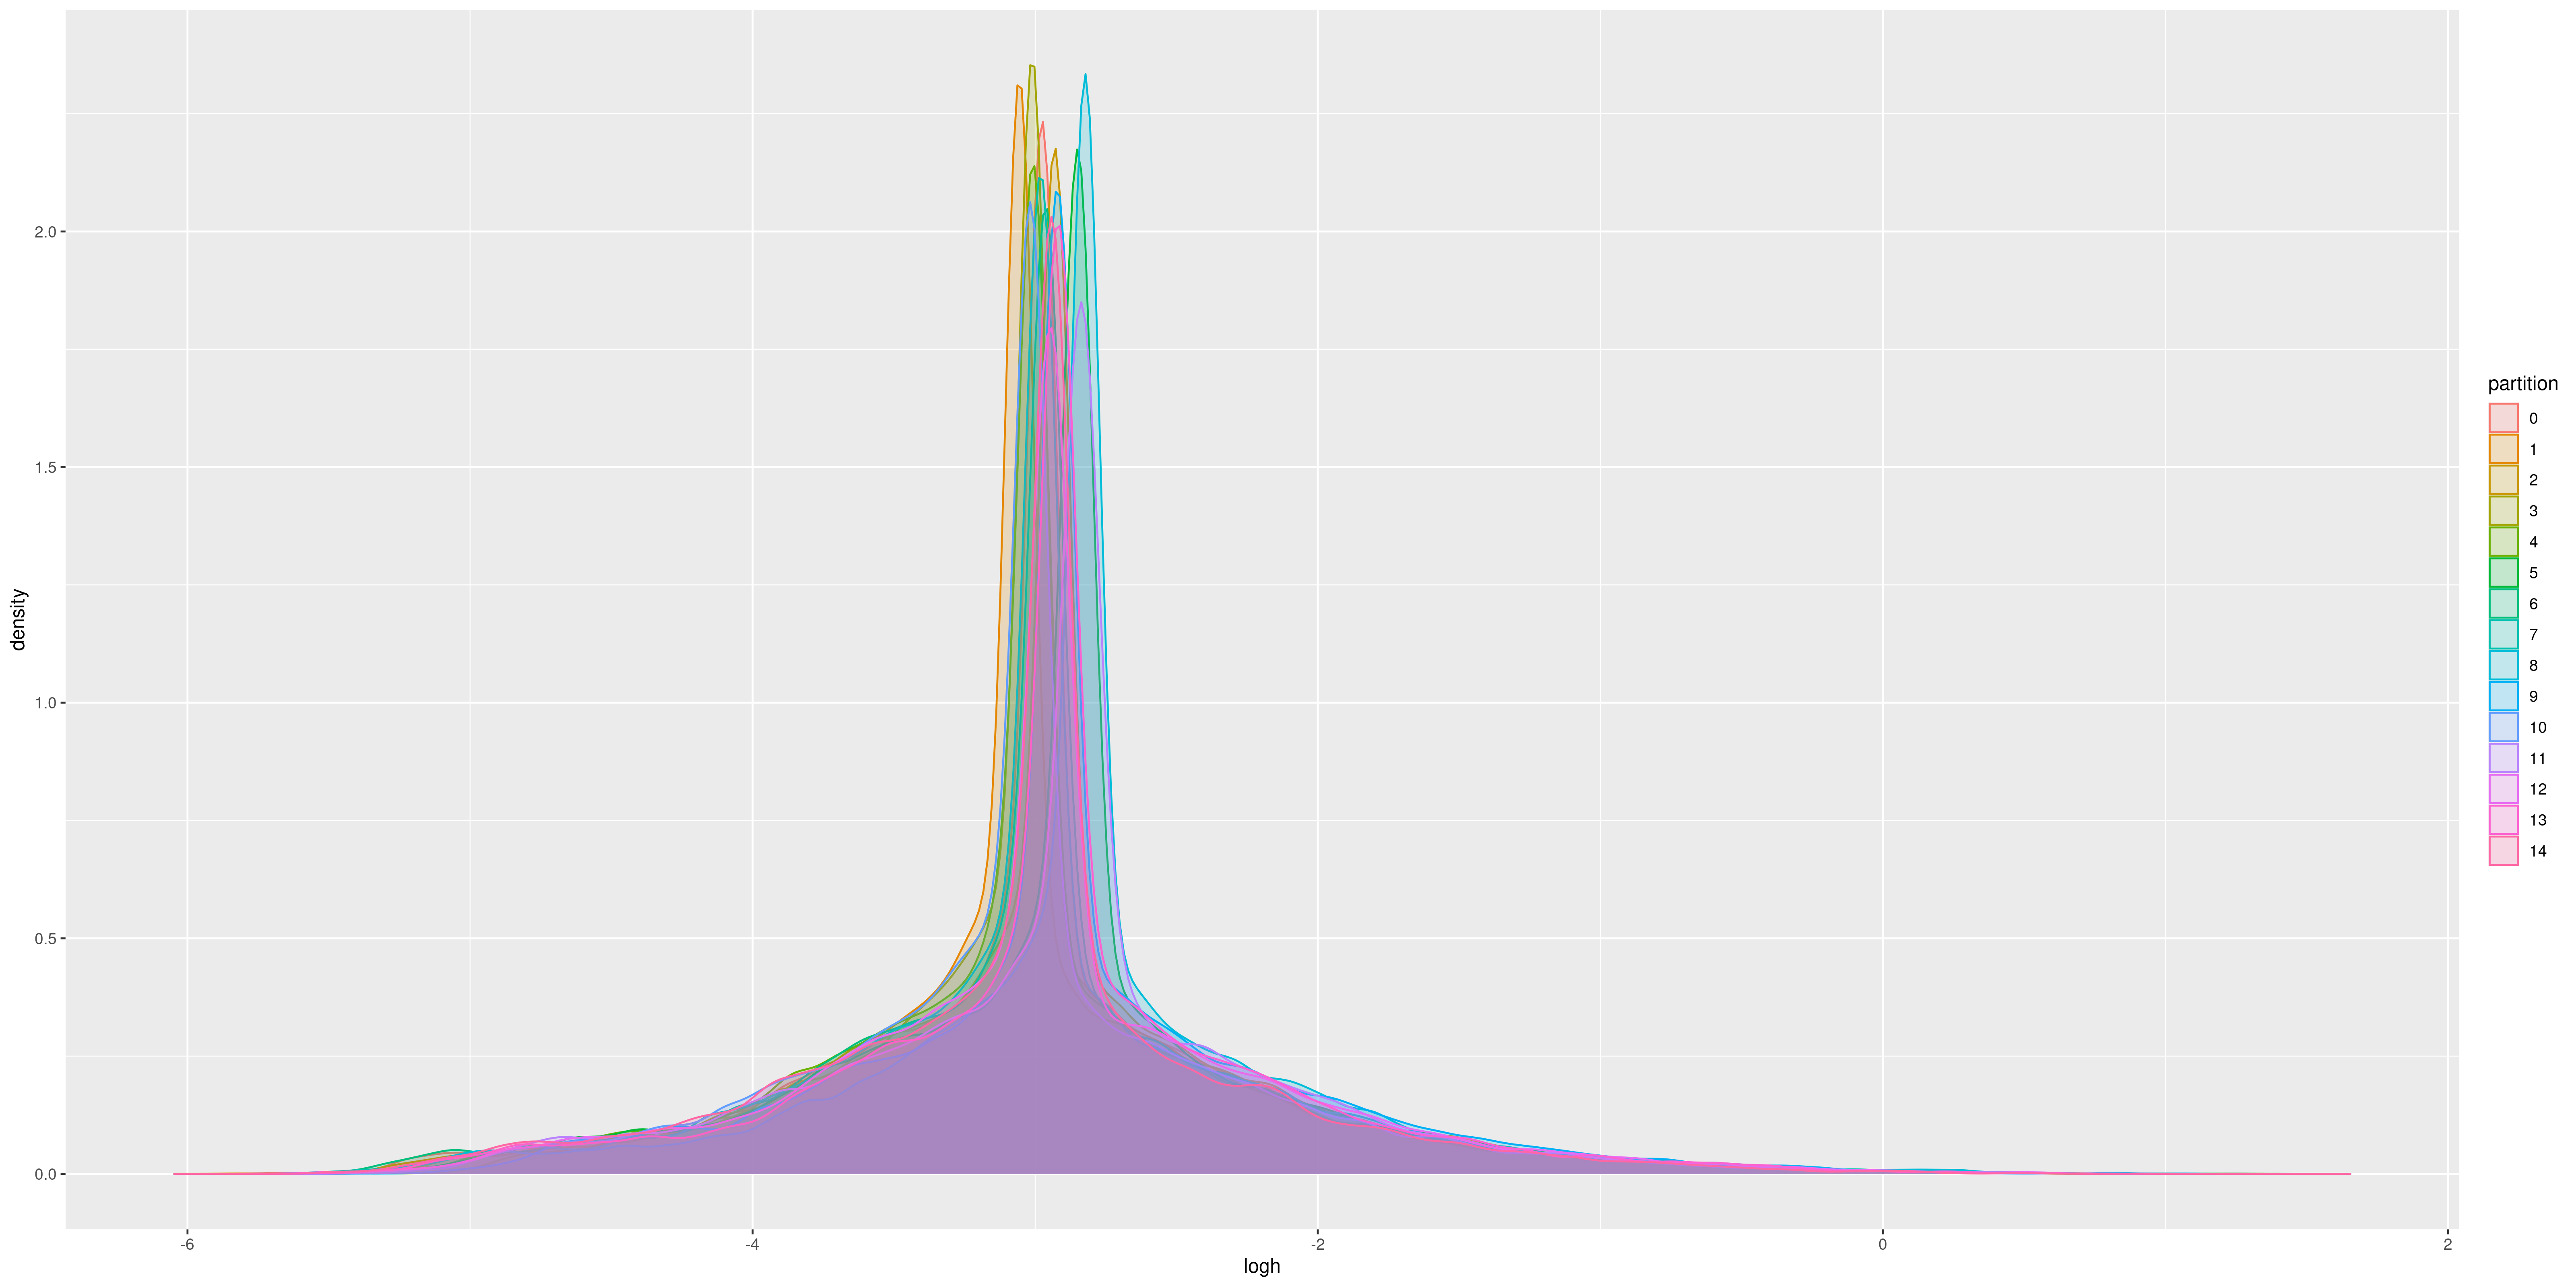

In [16]:
plot_width = 20; plot_height=10; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
temp %>% ggplot(aes(x=logh, color=partition, fill=partition)) + geom_density(alpha=0.2)

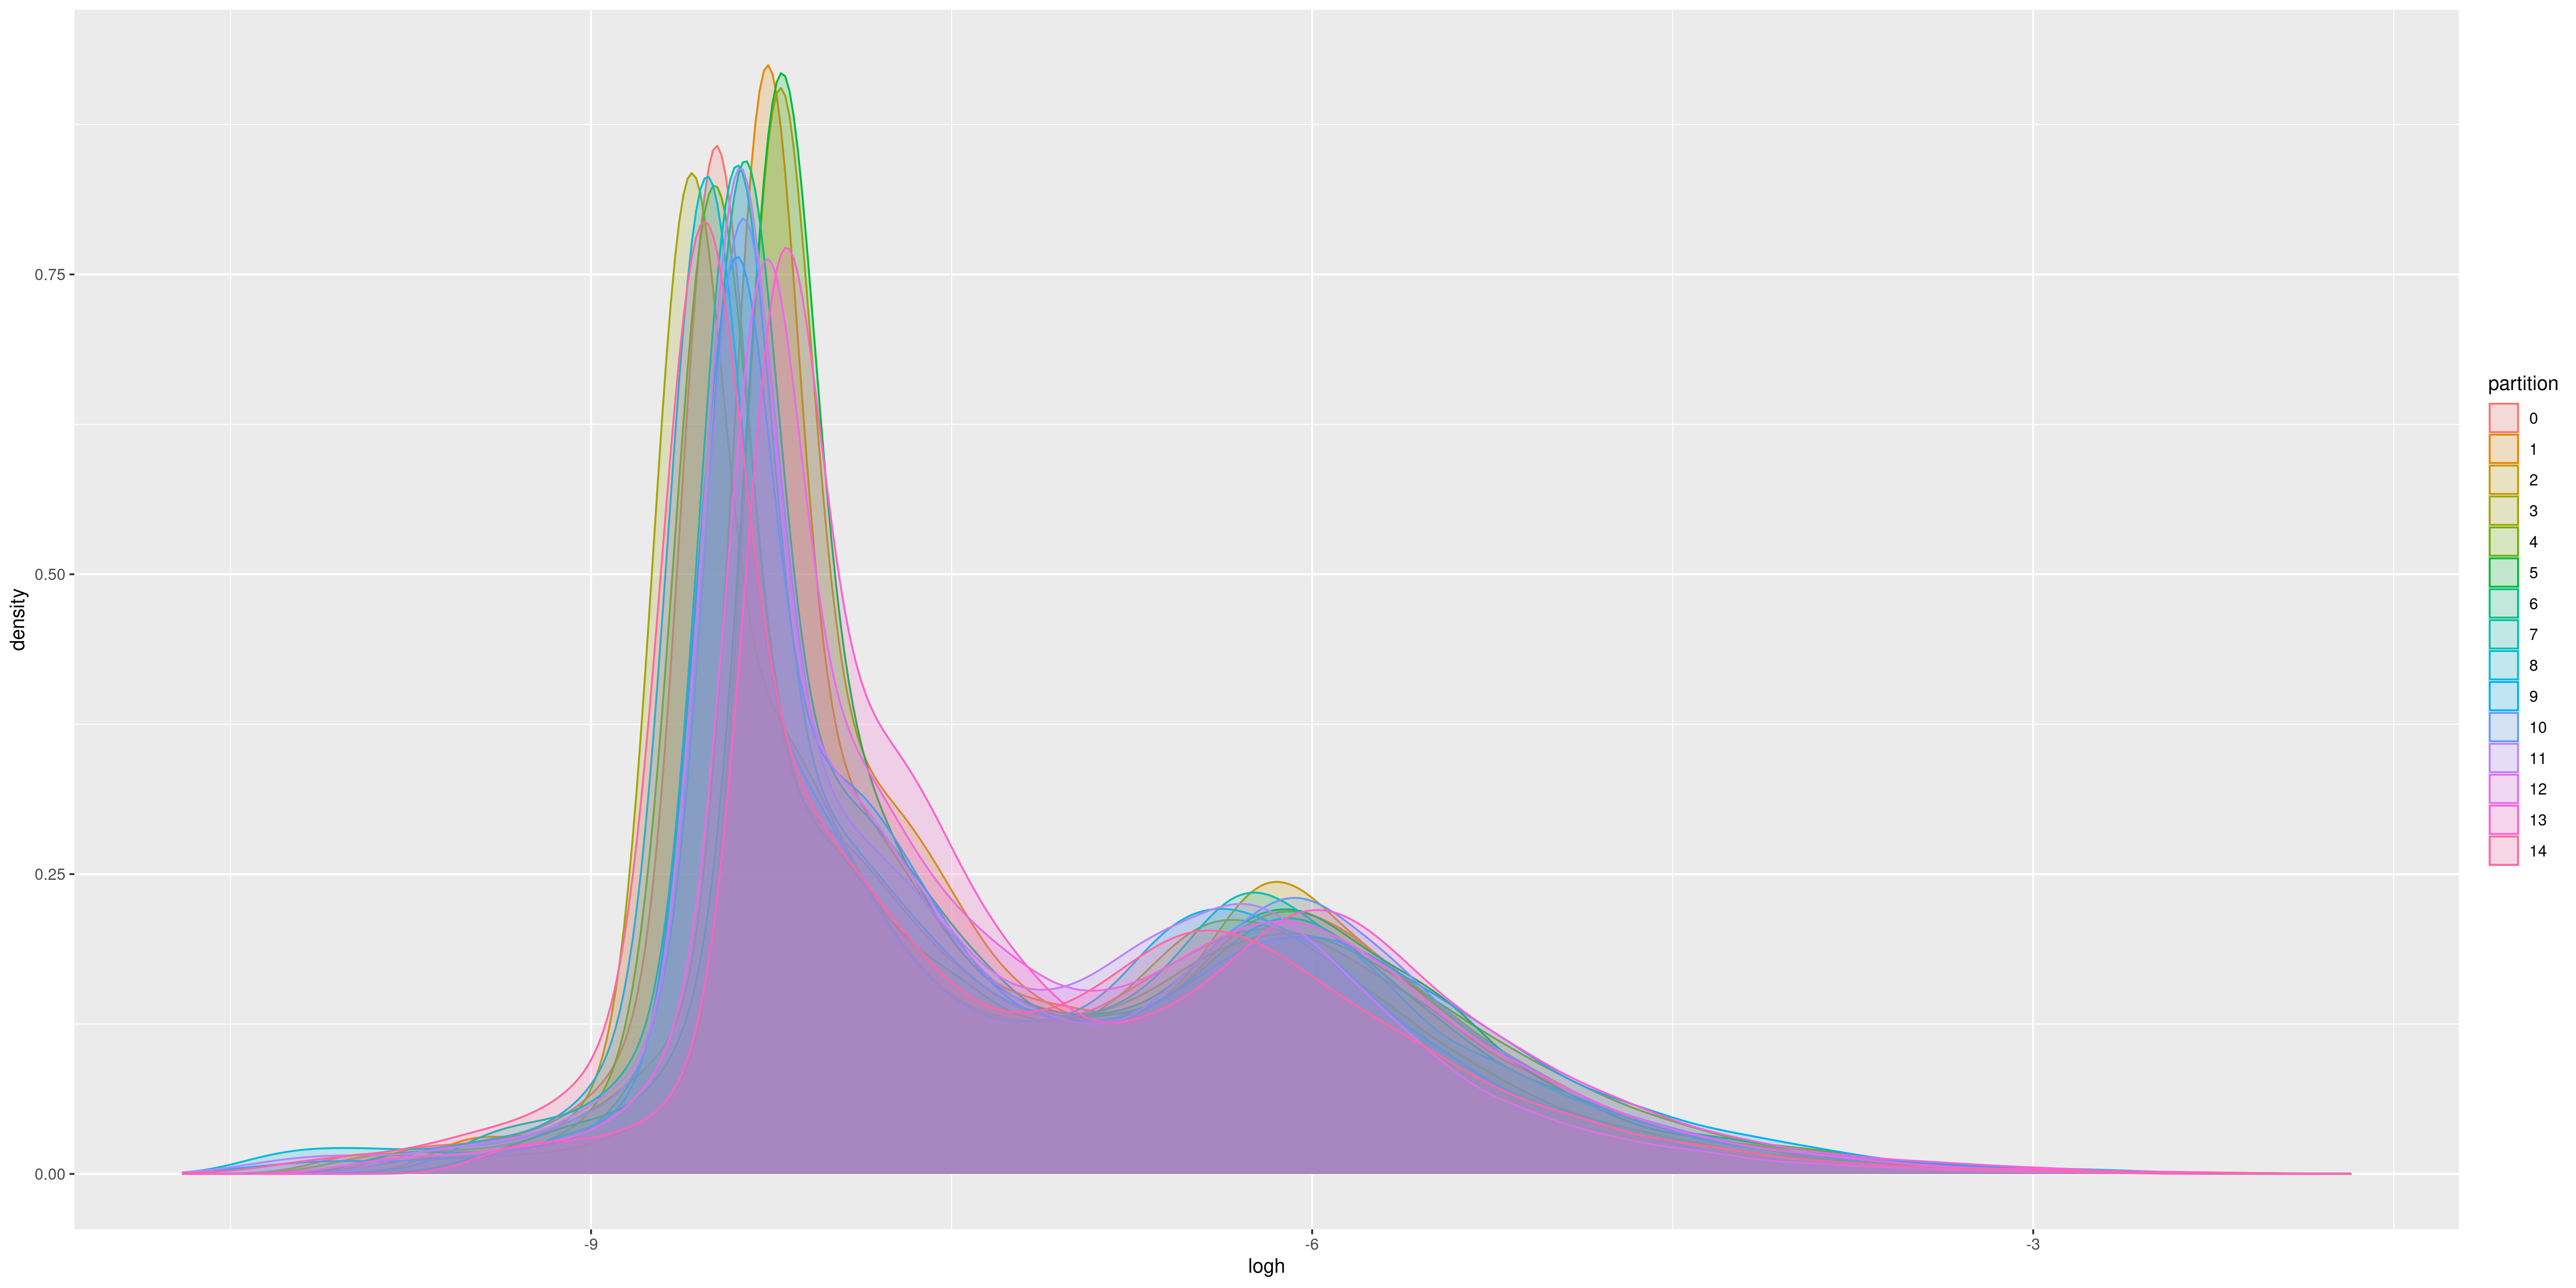

In [19]:
plot_width = 20; plot_height=10; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
temp %>% ggplot(aes(x=logh, color=partition, fill=partition)) + geom_density(alpha=0.2)

In [21]:
data_outcomes

Source: local data table [502,962,460 x 5]
Call:   `_DT1`

      eid endpoint     prevalent event  time
    <int> <chr>            <dbl> <dbl> <dbl>
1 1475839 OMOP_4306655         0     0 12.6 
2 1475840 OMOP_4306655         0     1  6.82
3 1475853 OMOP_4306655         0     0 12.8 
4 1475862 OMOP_4306655         0     0 11.7 
5 1475871 OMOP_4306655         0     0 11.9 
6 1475886 OMOP_4306655         0     0 12.6 
# … with 502,962,454 more rows

# Use as.data.table()/as.data.frame()/as_tibble() to access results

In [ ]:
cox_input = predictions %>% as_tibble() %>% left_join(data_outcomes %>% as_tibble(), by=c("eid", "endpoint"))

Joining, by = c("eid", "endpoint")



In [ ]:
data_prep = 

In [ ]:
fit_cox = function(data_prep, endpoint, features, covariates){
    data_temp = data_prep %>% mutate(event = !!sym(glue("{endpoint}_event")), time = !!sym(glue("{endpoint}_event_time"))) %>% select(all_of(covariates), event, time) 
    formula = as.formula(glue("Surv(time, event) ~ {paste(covariates, collapse='+' )}"))
    cox <- coxph(formula =formula, data= data_temp)
    }

In [ ]:
cox_input = 

In [ ]:
plot_width = 10; plot_height=10; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
temp %>% ggplot(aes(x=logh, color=partition, fill=partition)) + geom_density(alpha=0.2)

In [7]:
base_size = 8
title_size = 10
facet_size = 10
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2)))

In [8]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    "Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    "GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    "Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    "GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [9]:
phecode_defs_path = "/sc-projects/sc-proj-ukb-cvd/data/mapping/phecodes/phecode_strings_V2.csv"
phecode_defs = fread(phecode_defs_path, colClasses=c("character", "character", "character", "character", "integer", "character", "integer"))#, dtype={"phecode": str}).sort_values("phecode")
phecode_defs = phecode_defs %>% add_row(phecode = "4306655", phecode_string = "All-Cause Death", phecode_category = "Death", sex="Both")
phecode_defs = phecode_defs %>% as_tibble %>% separate(phecode, into=c("first", "second"), remove=FALSE) %>% 
    mutate(comb = str_remove_all(glue("{first}-{second}"), "-NA")) %>%
    mutate(endpoint=case_when(comb == "4306655" ~ glue("OMOP_{comb}"),
                              TRUE ~ glue("phecode_{comb}"))) %>%
    select(phecode, endpoint, everything(), -first, -second, -comb)
phecode_defs %>% sample_n(5)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 691 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 18, 20, 21, 24, 25, 26, 27, 29, 30, 31, ...].”


phecode,endpoint,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf
<chr>,<glue>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
604.3,phecode_604-3,Peyronie's disease,Genitourinary,Male,0,604,1
256.5,phecode_256-5,Hypokalemia [Hypopotassemia],Metab,Both,0,256,1
136.3,phecode_136-3,Benign neoplasm of the small intestine,Neoplasms,Both,0,136,1
340.1,phecode_340-1,Critical illness myopathy,Neuro,Both,0,340,1
433.21,phecode_433-21,Carotid artery stenosis,Cardio,Both,0,433,1


In [10]:
outcome_freq = data_outcomes %>% filter(prevalent==0) %>% group_by(endpoint) %>% summarize(freq = sum(event)/n()) %>% as_tibble()
outcome_freq %>% arrange(desc(freq))

endpoint,freq
<chr>,<dbl>
phecode_401,0.22535619
phecode_401-1,0.22471804
phecode_089,0.15780744
phecode_708,0.15229671
phecode_130,0.13742835
phecode_239,0.12403000
phecode_460,0.12011161
phecode_522,0.11723963
phecode_239-1,0.11561741


In [11]:
endpoint_map = phecode_defs$phecode_string
names(endpoint_map) =  phecode_defs$endpoint
endpoint_order_freq = (outcome_freq %>% arrange(desc(freq)))$endpoint

## Load data

In [12]:
list.dirs(path = project_path, full.names = TRUE, recursive = TRUE)

[1] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records"                        
[2] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/.ipynb_checkpoints"     
[3] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data"                   
[4] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data/.ipynb_checkpoints"
[5] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data/predictions"       
[6] "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/figures"

# Figure 2: Selected Endpoints

## Metabolic state and incident disease

In [13]:
pred_outcomes = predictions %>% left_join(data_outcomes, on=c(eid, endpoint)) %>% as.data.table() 

Joining, by = c("eid", "endpoint")



In [14]:
logh_inc = pred_outcomes %>% filter(prevalent==0) %>% group_by(endpoint, model) %>% mutate(logh_perc = ntile(logh, 100)) %>% ungroup() %>% as_tibble()

## No buffer

In [15]:
logh_T_agg = logh_inc %>% group_by(endpoint, model, logh_perc) %>% summarise(ratio = mean(event)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint', 'model'. You can override using the `.groups` argument.



In [16]:
logh_T_agg %>% write_feather(glue("{output_path}/logh_agg_220224.feather"))

In [17]:
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_T_agg %>% filter(model=="GNN(Records)+MLP") %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

mh_events = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Medical History Percentile [%]", y="Observed Event Rate [%]") +
    geom_point(alpha=0.7, size=0.1) + 
    scale_colour_gradient(
  low = "#7AC6FF",
  high = "#023768",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
    #scale_color_manual(values=c("Metabolomics"="black"))+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [18]:
plot_name = "MedicalHistoryRisk"
mh_events %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

In [19]:
plot_name = "MedicalHistoryRisk"
mh_events %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

## Add buffer

In [14]:
pred_outcomes %>% head()

eid,partition,model,endpoint,logh,prevalent,event,time
<int>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1475839,0,Identity(Records)+MLP,OMOP_4306655,-2.819316,0,0,12.564256
1475840,0,Identity(Records)+MLP,OMOP_4306655,-2.011223,0,1,6.817248
1475853,0,Identity(Records)+MLP,OMOP_4306655,-2.831062,0,0,12.772336
1475862,0,Identity(Records)+MLP,OMOP_4306655,-2.578309,0,0,11.660746
1475871,0,Identity(Records)+MLP,OMOP_4306655,-3.008898,0,0,11.879779
1475886,0,Identity(Records)+MLP,OMOP_4306655,-3.047699,0,0,12.646393


In [15]:
logh_T_agg_buffer = pred_outcomes %>% filter(prevalent==0) %>% mutate(event_buffer = case_when((event!=0&time<1) ~ 0, TRUE ~ event)) %>% group_by(endpoint, model) %>% mutate(logh_perc = ntile(logh, 100)) %>% group_by(endpoint, model, logh_perc) %>% summarise(ratio = mean(event_buffer)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint', 'model'. You can override using the `.groups` argument.



In [16]:
logh_T_agg_buffer %>% write_feather(glue("{output_path}/logh_agg_1ybuffer_220224.feather"))

In [17]:
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_T_agg_buffer %>% filter(model=="GNN(Records)+MLP") %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

mh_events = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Medical History Percentile [%]", y="Observed Event Rate [%]") +
    geom_point(alpha=0.7, size=0.1) + 
    scale_colour_gradient(
  low = "#7AC6FF",
  high = "#023768",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
    #scale_color_manual(values=c("Metabolomics"="black"))+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [18]:
plot_name = "MedicalHistoryRisk_1ybuffer"
mh_events %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

## Metabolomic State and Event Trajectories

In [19]:
logh_mh = logh_inc %>% select(endpoint, model, eid, logh_perc, event, time) %>% group_by(endpoint) %>% 
    mutate(MH=case_when(logh_perc %in% 91:100 ~ "High", 
                        logh_perc %in% 45:55 ~ "Mid", 
                        logh_perc %in% 1:10 ~ "Low",
                        TRUE ~ "NA")
          ) %>% mutate(MET = fct_rev(factor(MET, levels=c("Low", "Mid", "High")))) %>% ungroup() %>% 
    filter(MH!="NA") #%>% select(eid, endpoint, logh, logh_group)

In [23]:
require("ggquickeda")
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
met_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_mh %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() 

km_plot = ggplot(temp, aes(time = time, status = event, fill=MET, color=MET,group=MET)) +
    geom_km(trans = "event") + 
    geom_kmticks(trans = "event", size=0.3) + geom_kmband(trans = "event") + 
    labs(x="Time [Years]", y="Cumulative Events [%]")+
    scale_color_manual(values=met_map)+scale_fill_manual(values=met_map)+
    scale_y_continuous(labels = function(x) round(x*100, 1), expand=c(0, 0))+
    scale_x_continuous(expand=expansion(add=c(0, .1)), breaks=c(5, 10))+
    facet_wrap(~ endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [ ]:
plot_name = "MedicalHistory_KMs"
km_plot %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

# Top 1%

In [26]:
logh_mh = logh_inc %>% select(endpoint, model, eid, logh_perc, event, time) %>% group_by(endpoint) %>% 
    mutate(MH=case_when(logh_perc == 100 ~ "High", 
                        logh_perc %in% 50:51 ~ "Mid", 
                        logh_perc == 1 ~ "Low",
                        TRUE ~ "NA")
          ) %>% mutate(MET = fct_rev(factor(MH, levels=c("Low", "Mid", "High")))) %>% ungroup() %>% 
    filter(MH!="NA") #%>% select(eid, endpoint, logh, logh_group)

In [27]:
require("ggquickeda")
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
mh_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_mh %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() 

km_plot = ggplot(temp, aes(time = time, status = event, fill=MH, color=MH,group=MH)) +
    geom_km(trans = "event") + 
    geom_kmticks(trans = "event", size=0.3) + geom_kmband(trans = "event") + 
    labs(x="Time [Years]", y="Cumulative Events [%]")+
    scale_color_manual(values=met_map)+scale_fill_manual(values=mh_map)+
    scale_y_continuous(labels = function(x) round(x*100, 1), expand=c(0, 0))+
    scale_x_continuous(expand=expansion(add=c(0, .1)), breaks=c(5, 10))+
    facet_wrap(~ endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [28]:
plot_name = "MedicalHistory_KMs_Top1"
km_plot %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

# Figure 2

In [ ]:
plot_width=8.25; plot_height=10; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig2 = met_events / km_plot# +plot_annotation(tag_levels = 'A')

In [ ]:
fig2

In [ ]:
library(gt)
plot_name = "Figures_2_AB"
fig2 %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=320)